In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read data
df = pd.read_csv('../data/count/Q1.csv')
df['sum'] = df['fhv']+df['fhvhv']
df['fhvpool'] = df['fhv']/df['sum']

df['month'] = df['year']*100+df['month']
df = df.drop(columns=['year'])

df.head()

,month,fhv,fhvhv,sum,fhvpool
0,201501,2720786,0,2720786,1.0
1,201502,3053183,0,3053183,1.0
2,201503,3245472,0,3245472,1.0
3,201504,3874538,0,3874538,1.0
4,201505,4232122,0,4232122,1.0


       month      fhv  fhvhv      sum  fhvpool
0 2015-01-01  2720786      0  2720786      1.0
1 2015-02-01  3053183      0  3053183      1.0
2 2015-03-01  3245472      0  3245472      1.0
3 2015-04-01  3874538      0  3874538      1.0
4 2015-05-01  4232122      0  4232122      1.0


/var/folders/p7/3vzsfzqd7xg1gkp_lyrvwhhw0000gn/T/ipykernel_77477/2689969812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['month'] = pd.to_datetime(df1['month'], format='%Y%m')


<Axes: xlabel='month'>

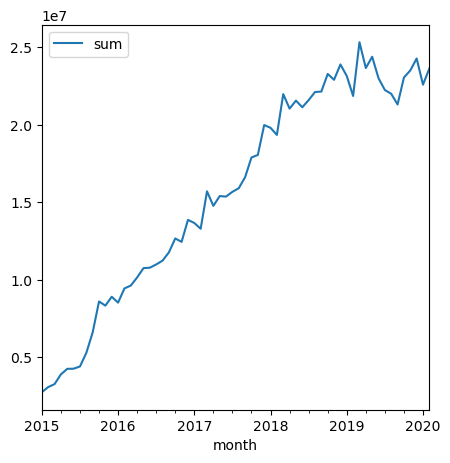

In [2]:

df1 = df[df['month']<202003]
df1.head()

df1['month'] = pd.to_datetime(df1['month'], format='%Y%m')
print(df1.head())
df1.plot(x='month', y='sum', figsize=(5,5))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

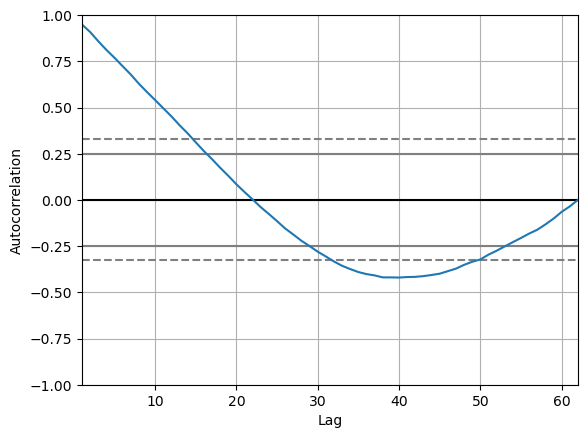

In [3]:
pd.plotting.autocorrelation_plot(df1['sum'])

[ 1.04382853 -0.06405468  0.08111447 63.09558576]
RMSE: 0.03773651263447186


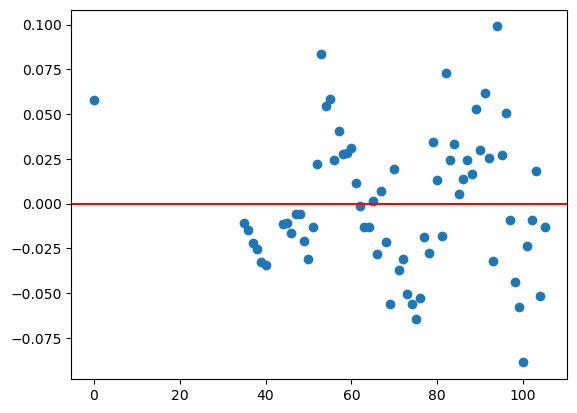

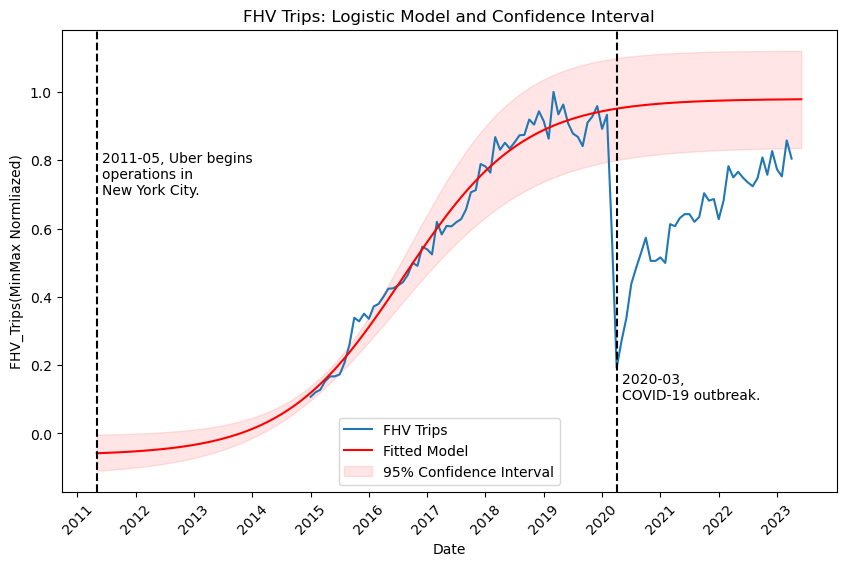

In [10]:
## Logistic Model Fit and Confidence Interval for Normalized FHV Trips Over Time

from scipy.optimize import curve_fit
#为df1['month']添加序号,从44开始
x = np.arange(44, 44+len(df1['month']))
y = df1['sum'].to_numpy()




#在x和y的第一位添加0
x = np.insert(x, 0, [0,35,36,37,38,39,40])
y = np.insert(y,0,[1500,564516,652435,663844,796121,829275,1028136])

# 对y进行归一化
y = y / y.max()

def logistic(x, a, b, c, d):
    return a / (1. + np.exp(-np.clip(c * (x - d), -100, 100))) + np.clip(b, -0.15,100)

p0 = [1, 0, 0.1, 0.6]
params, params_covariance = curve_fit(logistic, x, y, p0=p0)
params_error = np.sqrt(np.diag(params_covariance))

print(params)


# calculate the MSE
mse = np.mean((logistic(x, *params) - y) ** 2)
rmse = np.sqrt(mse)
print('RMSE: {}'.format(rmse))  # RMSE: 0.0398


# plot the residual
residual = y - logistic(x, *params)
plt.scatter(x, residual)
plt.axhline(y=0, color='r', linestyle='-')



dates = pd.date_range('2011-01', '2023-05', freq='M')
y2 = df['sum'].to_numpy()/df['sum'].max()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(len(df))+48, y2, label='FHV Trips')
ax.plot(np.arange(146)+4, logistic(np.arange(146), *params), color='red', label='Fitted Model')

# Calculate the standard error of the parameters
params_se = np.sqrt(np.diag(params_covariance))

# Calculate the prediction interval
pi_upper = logistic(np.arange(146), *(params + 1.96 * params_se))
pi_lower = logistic(np.arange(146), *(params - 1.96 * params_se))

# Plot the 95% prediction interval
ax.fill_between(np.arange(146)+4, pi_upper, pi_lower, color='red', alpha=0.1, label='95% Confidence Interval')



# add a vertical line
ax.axvline(x=49+len(df1['month']), color='k', linestyle='--')
ax.axvline(x=4, color='k', linestyle='--')

# add legend for each vertical line near the line
ax.text(48+len(df1['month'])+2, 0.1, '2020-03,\nCOVID-19 outbreak.', fontsize=10)
ax.text(4+1, 0.7, '2011-05, Uber begins\noperations in\nNew York City.', fontsize=10)




years = dates.year.unique()  # 获取所有的年份
ax.set_xticks([np.where(dates.year == year)[0][0] for year in years])  # 将每年的第一个月作为刻度
ax.set_xticklabels(years, rotation=45)

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('FHV_Trips(MinMax Normliazed)')
plt.title('FHV Trips: Logistic Model and Confidence Interval')


plt.show()



In [5]:
print(np.diag(params_covariance))

[1.82164524e-03 8.68896349e-04 3.21851200e-05 7.23235951e-01]


In [6]:
uber04 = pd.read_csv('../data/odata/csv/uber_201404.csv')
uber05 = pd.read_csv('../data/odata/csv/uber_201405.csv')
uber06 = pd.read_csv('../data/odata/csv/uber_201406.csv')
uber07 = pd.read_csv('../data/odata/csv/uber_201407.csv')
uber08 = pd.read_csv('../data/odata/csv/uber_201408.csv')
uber09 = pd.read_csv('../data/odata/csv/uber_201409.csv')

In [7]:
print(uber04.shape)
print(uber05.shape)
print(uber06.shape)
print(uber07.shape)
print(uber08.shape)
print(uber09.shape)

(564516, 4)
(652435, 4)
(663844, 4)
(796121, 4)
(829275, 4)
(1028136, 4)


In [37]:
## 统计各区域总trips，使用wilcoxon signed-rank test检验
# 创建一个空的DataFrame，包括如下列：['LocationID', 'Trips19'，‘Trips23’]
flow = pd.DataFrame(columns=['LocationID', 'Trips19', 'Trips23'])

# LocationID 为 1-263
flow['LocationID'] = np.arange(1, 264)

# set trips to 0
flow['Trips19'] = 0
flow['Trips23'] = 0


# 读取2019年数据
for i in range(2, 5):
    df = pd.read_csv(f'../data/count/q2/step1/do_fhv190{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['dolocationid']=df['dolocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='dolocationid', how='left')
    flow['Trips19'] = flow['Trips19'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips19'] = flow['Trips19'] + flow['count']
    flow = flow.drop(columns=['dolocationid', 'count'])
    
    df = pd.read_csv(f'../data/count/q2/step1/do_hvfhv190{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['dolocationid']=df['dolocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='dolocationid', how='left')
    flow['Trips19'] = flow['Trips19'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips19'] = flow['Trips19'] + flow['count']
    flow = flow.drop(columns=['dolocationid', 'count'])

    df = pd.read_csv(f'../data/count/q2/step1/pu_fhv190{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['pulocationid']=df['pulocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='pulocationid', how='left')
    flow['Trips19'] = flow['Trips19'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips19'] = flow['Trips19'] + flow['count']
    flow = flow.drop(columns=['pulocationid', 'count'])

    df = pd.read_csv(f'../data/count/q2/step1/pu_hvfhv190{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['pulocationid']=df['pulocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='pulocationid', how='left')
    flow['Trips19'] = flow['Trips19'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips19'] = flow['Trips19'] + flow['count']
    flow = flow.drop(columns=['pulocationid', 'count'])

# 读取2023年数据
for i in range(2, 5):
    df = pd.read_csv(f'../data/count/q2/step1/do_fhv230{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['dolocationid']=df['dolocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='dolocationid', how='left')
    flow['Trips23'] = flow['Trips23'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips23'] = flow['Trips23'] + flow['count']
    flow = flow.drop(columns=['dolocationid', 'count'])

    df = pd.read_csv(f'../data/count/q2/step1/do_hvfhv230{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['dolocationid']=df['dolocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='dolocationid', how='left')
    flow['Trips23'] = flow['Trips23'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips23'] = flow['Trips23'] + flow['count']
    flow = flow.drop(columns=['dolocationid', 'count'])
    
    df = pd.read_csv(f'../data/count/q2/step1/pu_fhv230{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['pulocationid']=df['pulocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='pulocationid', how='left')
    flow['Trips23'] = flow['Trips23'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips23'] = flow['Trips23'] + flow['count']
    flow = flow.drop(columns=['pulocationid', 'count'])

    df = pd.read_csv(f'../data/count/q2/step1/pu_hvfhv230{i}.csv')
    df = df.dropna(axis=0, how='any')
    df['pulocationid']=df['pulocationid'].astype(int)
    flow = flow.merge(df, left_on='LocationID',right_on='pulocationid', how='left')
    flow['Trips23'] = flow['Trips23'].fillna(0)
    flow['count'] = flow['count'].fillna(0)
    flow['Trips23'] = flow['Trips23'] + flow['count']
    flow = flow.drop(columns=['pulocationid', 'count'])

# trips/2
flow['Trips19'] = flow['Trips19']/2
flow['Trips23'] = flow['Trips23']/2

# 计算百分比
flow['flowrate'] = flow['Trips23']/flow['Trips19']

#discribe the flowrate
print(flow['flowrate'].describe())

# save the flowrate
flow.to_csv('../data/count/q2/step1/tripcount.csv', index=False)
flow.head()

count    262.000000
mean       0.970275
std        0.433151
min        0.000000
25%        0.829428
50%        0.908622
75%        1.030121
max        6.400000
Name: flowrate, dtype: float64


,LocationID,Trips19,Trips23,flowrate
0,1,174655.5,203150.5,1.163150
1,2,109.0,115.5,1.059633
2,3,122016.0,121263.0,0.993829
3,4,270625.0,188485.5,0.696482
4,5,13545.0,15831.0,1.168771


In [38]:
from scipy.stats import wilcoxon

# create array for 19 and 23
trips19 = flow['Trips19'].to_numpy()
trips23 = flow['Trips23'].to_numpy()

# perform the wilcoxon signed-rank test
stat, p = wilcoxon(trips19, trips23)
print('Statistics=%.3f, p=%.3f' % (stat, p)) # Statistics=6403.500, p=0.000

Statistics=6403.500, p=0.000


/var/folders/p7/3vzsfzqd7xg1gkp_lyrvwhhw0000gn/T/ipykernel_62824/3850314442.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trips19 = trips19.groupby(['day_of_week', 'hour']).mean()
/var/folders/p7/3vzsfzqd7xg1gkp_lyrvwhhw0000gn/T/ipykernel_62824/3850314442.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trips23 = trips23.groupby(['day_of_week', 'hour']).mean()


Text(0.5, 1.0, 'Ratio of Trips in day of week and hour')

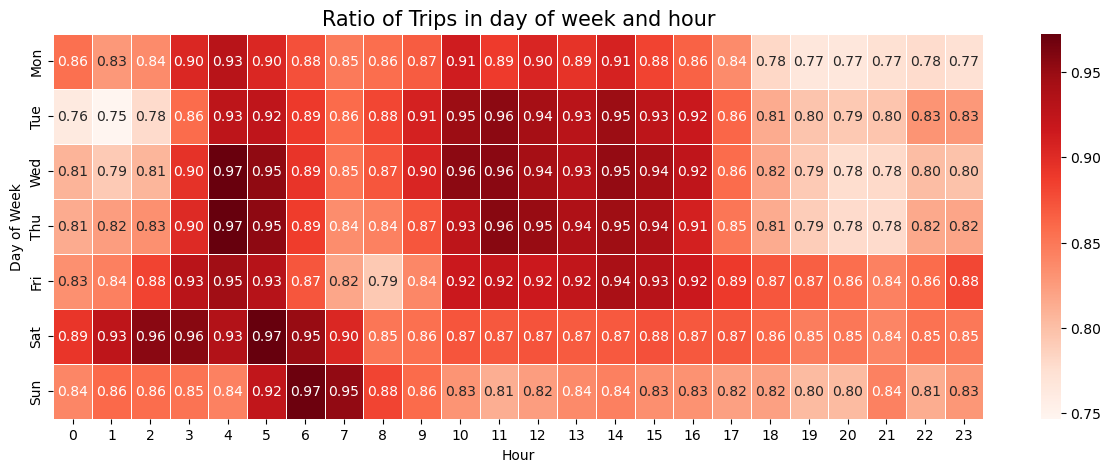

In [28]:
## 绘制7*24小时流量比例矩阵图

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
trips19 = pd.read_csv('../data/count/q1/trips_by_hour_19.csv.csv')
trips23 = pd.read_csv('../data/count/q1/trips_by_hour_23.csv.csv')

# 计算每周同一天同一小时的平均流量
# 构造day_of_week和hour列
# 将pīckup_datetime转换为datetime类型
trips19['pickup_datetime'] = pd.to_datetime(trips19['pickup_hour'])
trips23['pickup_datetime'] = pd.to_datetime(trips23['pickup_hour'])
# 提取day_of_week和hour
trips19['day_of_week'] = trips19['pickup_datetime'].dt.dayofweek
trips19['hour'] = trips19['pickup_datetime'].dt.hour
trips23['day_of_week'] = trips23['pickup_datetime'].dt.dayofweek
trips23['hour'] = trips23['pickup_datetime'].dt.hour
# 计算每周同一天同一小时的平均流量
trips19 = trips19.groupby(['day_of_week', 'hour']).mean()
trips23 = trips23.groupby(['day_of_week', 'hour']).mean()
# 重置索引
trips19 = trips19.reset_index()
trips23 = trips23.reset_index()

# 计算比例
# 建立空的比例矩阵
ratio = np.zeros((7, 24))
# 计算比例
for i in range(7):
    for j in range(24):
        ratio[i, j] = trips23['trips'][i * 24 + j] / trips19['trips'][i * 24 + j]

# 绘制热力图
plt.figure(figsize=(15, 5))
sns.heatmap(ratio, cmap='Reds', annot=True, fmt='.2f', linewidths=.5)
plt.xlabel('Hour')
plt.ylabel('Day of Week')
# 设置坐标轴刻度
plt.xticks(np.arange(0.5, 24.5, 1), np.arange(0, 24, 1))

# 设置坐标轴标签
plt.yticks(np.arange(0.5, 7.5, 1), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.title('Ratio of Trips in day of week and hour', fontsize=15)